In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
import gammapy
import logging
import os
import numpy as np
import astropy.units as u
from matplotlib.colors import LogNorm
from gammapy.extern import xmltodict
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion, PixCoord
from gammapy.utils.energy import EnergyBounds
from gammapy.utils.fitting import Fit
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    models,
    FluxPointsEstimator,
    FluxPointsDataset,
)
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom
from gammapy.cube import MapMaker
from gammapy.background import ReflectedRegionsBackgroundEstimator, RingBackgroundEstimator
from gammapy.detect import TSMapEstimator, find_peaks
from gammapy.data import DataStore
from gammapy.spectrum.models import PowerLaw
print("numpy:", np.__version__)
print("astropy:", astropy.__version__)
print("gammapy:", gammapy.__version__)

numpy: 1.16.4
astropy: 3.1.2
gammapy: 0.12


In [3]:
SkyCoord.from_name("M82")

<SkyCoord (ICRS): (ra, dec) in deg
    (148.96845833, 69.67970278)>

In [4]:
SkyCoord.from_name("Crab")

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>

In [6]:
from gammapy.data import EventList
path = "/home/rishank/events/M82_events_01.fits"
events = EventList.read(path)

In [7]:
events.table

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,631108933.7348348,148.98871,69.4386,0.040470283,-0.5613997,-0.003966285,1
2,631108945.2555282,149.12408,69.57583,0.038381916,-0.42412484,0.043304034,1
3,631108945.9031234,148.84232,69.62071,0.0610977,-0.37921298,-0.054912496,1
4,631109015.6288189,149.23306,69.46351,0.043604165,-0.53633714,0.08175998,1
5,631109045.5571501,148.63983,69.553566,0.06637145,-0.446063,-0.12581809,1
6,631109066.9523954,149.08723,69.90808,0.044284593,-0.091895476,0.029965797,1
7,631109135.6018658,148.85443,69.7598,0.035714697,-0.24013877,-0.050362043,1
8,631109211.8636605,149.35262,69.589714,0.05759755,-0.4099317,0.12297262,1


In [9]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.

logging.basicConfig()
log = logging.getLogger("gammapy.spectrum")
log.setLevel(logging.ERROR)


In [11]:
os.environ['CALDB'] = '/home/rishank/gammapy-datasets/cta-1dc/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/gammapy-datasets/cta-1dc/caldb/
data


In [17]:
from pathlib import Path
path = Path("/home/rishank/events")
paths = list(path.rglob("M82*.fits"))
data_store = DataStore.from_events_files(paths)
observations = data_store.get_observations()
#from gammapy.data import DataStore
#path = "/home/rishank/M82_events.fits"
#data_store = DataStore.from_events_files([path])
#observations = data_store.get_observations()

In [18]:
data_store.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,TELESCOP,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
,deg,deg,deg,deg,deg,deg,deg,s,s,,s,s,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,str13,str13,str13,int64,str1,str3,str3,str13,str39,int64
2,149.0,70.0,141.0596369493065,40.38835957653765,0.0,90.0,0.0,259200.0,254016.0,0.98,631454469.18,631713669.18,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,0,,CTA,1dc,South_z20_50h,/home/rishank/events/M82_events_02.fits,13944946
1,149.0,70.0,141.0596369493065,40.38835957653765,0.0,90.0,0.0,259200.0,254016.0,0.98,631108869.18,631368069.18,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,0,,CTA,1dc,South_z20_50h,/home/rishank/events/M82_events_01.fits,13944946


In [19]:
is_gamma = events.table["MC_ID"] == 1
print("Number of events: ", len(events.table))
print("Number of gammas: ", is_gamma.sum())
print("Number of hadrons: ", len(events.table) - is_gamma.sum())

Number of events:  13944946
Number of gammas:  28402
Number of hadrons:  13916544


In [20]:
ra = events.table["RA"].data
dec = events.table["DEC"].data
print(ra.mean())
print(dec.mean())
gamma_ra = ra[is_gamma].mean()
print(gamma_ra)
gamma_dec = dec[is_gamma].mean()
print(gamma_dec)
d = SkyCoord(ra=gamma_ra*u.degree, dec=gamma_dec*u.degree, frame='icrs')
d.galactic

148.9997
69.97016
148.971
69.679375


<SkyCoord (Galactic): (l, b) in deg
    (141.40914188, 40.5678682)>

In [21]:
table = data_store.obs_table
c = SkyCoord(ra=table['RA_PNT'], dec=table['DEC_PNT'], frame='icrs')
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    [(141.05963695, 40.38835958), (141.05963695, 40.38835958)]>

<SkyCoord (Galactic): (l, b) in deg
    (141.05963695, 40.38835958)>

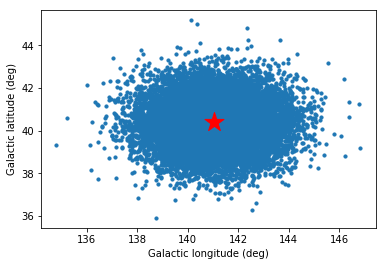

In [22]:
# Event positions
pos = events.galactic[::1000]  # sub-sample every 100th event
plt.scatter(pos.l.wrap_at("180 deg").deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(
    pos_pnt.l.wrap_at("180 deg").deg, pos_pnt.b.deg, marker="*", s=400, c="red"
)
plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
pos_pnt

<SkyCoord (Galactic): (l, b) in deg
    (141.05963695, 40.38835958)>

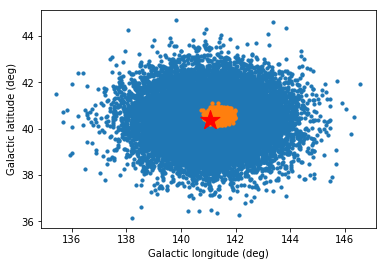

In [23]:
# Event positions
pos = events.galactic[~is_gamma][::1000]  # sub-sample every 100th event
plt.scatter(pos.l.wrap_at("180 deg").deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(
    pos_pnt.l.wrap_at("180 deg").deg, pos_pnt.b.deg, marker="*", s=400, c="red"
)
plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
pos_pnt


#Event positions
pos = events.galactic[is_gamma][::1]  # sub-sample every 100th event
plt.scatter(pos.l.wrap_at("180 deg").deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(
    pos_pnt.l.wrap_at("180 deg").deg, pos_pnt.b.deg, marker="*", s=400, c="red"
)
plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
pos_pnt

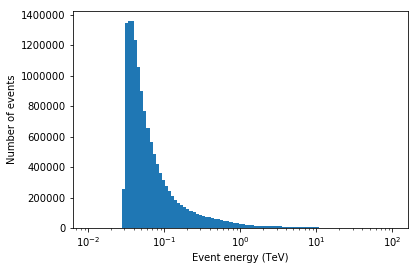

In [24]:
energy = events.table["ENERGY"].data
energy_bins = np.logspace(-2, 2, num=100)
plt.hist(energy, bins=energy_bins)
plt.semilogx()
plt.xlabel("Event energy (TeV)")
plt.ylabel("Number of events");

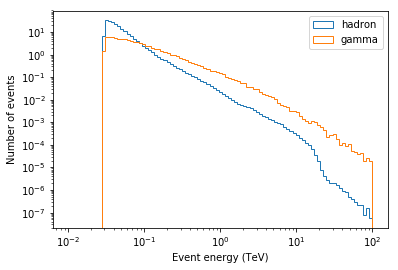

In [25]:
energy = events.table["ENERGY"].data
energy_bins = np.logspace(-2, 2, num=100)
opts = dict(bins=energy_bins, density=True, histtype="step")
plt.hist(energy[~is_gamma], label="hadron", **opts)
plt.hist(energy[is_gamma], label="gamma", **opts)
plt.loglog()
plt.xlabel("Event energy (TeV)")
plt.ylabel("Number of events")
plt.legend();

Text(0,0.5,'Offset (deg)')

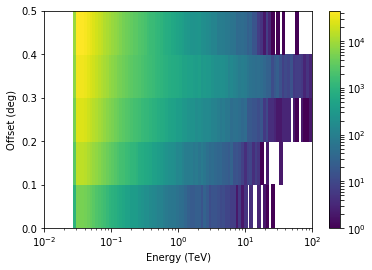

In [26]:

energy_bins = 10 ** np.linspace(-2, 2, 100)
offset_bins = np.arange(0, 0.6, 0.1)

t = events.table
offset = np.sqrt(t["DETX"] ** 2 + t["DETY"] ** 2)
hist = np.histogram2d(
    x=t["ENERGY"], y=offset, bins=(energy_bins, offset_bins)
)[0].T

plt.pcolormesh(energy_bins, offset_bins, hist, norm=LogNorm())
plt.semilogx()
plt.colorbar()
plt.xlabel("Energy (TeV)")
plt.ylabel("Offset (deg)")

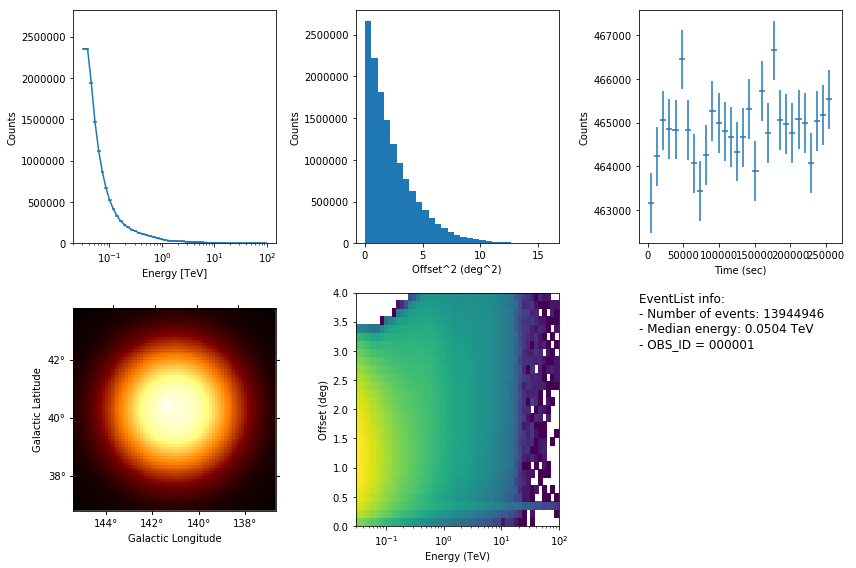

In [27]:
events.peek()

In [28]:
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(d.galactic.l.deg, d.galactic.b.deg), npix=(250, 200), binsz=0.02, coordsys="GAL", axes=[axis]
)
geom

WcsGeom

	axes       : lon, lat, energy
	shape      : (250, 200, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 141.4 deg, 40.6 deg
	width      : 5.0 deg x 4.0 deg

In [87]:
target_position = SkyCoord(d.galactic.l.deg, d.galactic.b.deg, unit="deg", frame="galactic")
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (250, 200)
	ndim  : 2
	unit  : '' 
	dtype : bool 



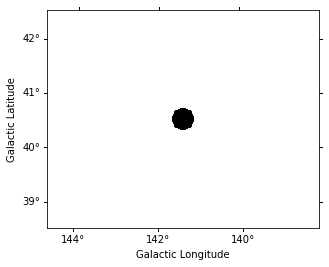

In [88]:
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
print(exclusion_mask)
exclusion_mask.plot();

CPU times: user 1min 4s, sys: 15.3 s, total: 1min 20s
Wall time: 1min 51s


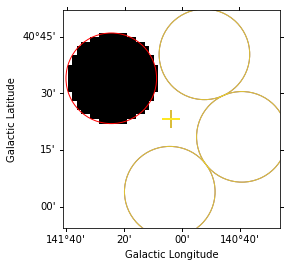

In [89]:
%%time
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    observations=observations,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot();

In [90]:
print('1\n',bkg_estimator.finder.reference_map.geom.wcs)
wcs = bkg_estimator.finder.reference_map.geom.wcs

print('2\n',bkg_estimator.finder.region.to_pixel(wcs))
bkg_estimator.finder._pix_region = bkg_estimator.finder.region.to_pixel(wcs)
print('3\n',bkg_estimator.finder._pix_region.radius)

bkg_estimator.finder._pix_center = PixCoord(*bkg_estimator.finder.center.to_pixel(wcs))
print('4',bkg_estimator.finder._pix_center.x)
print('5',bkg_estimator.finder.center.to_pixel(wcs))
print('6',bkg_estimator.finder._offset)
center = bkg_estimator.finder.center
print('7',bkg_estimator.finder.center)
print('8',bkg_estimator.finder.region.center)
print('9',bkg_estimator.finder.reference_map)
print('10',center)


1
 WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 141.0596369493065  40.38835957653765  
CRPIX : 24.5  24.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.02  0.02  
NAXIS : 48  48
2
 Region: CirclePixelRegion
center: PixCoord(x=10.225045449787054, y=32.501792474201096)
radius: 10.000205672559789
3
 10.000205672559789
4 23.5
5 (array(23.5), array(23.5))
6 16.03922336208353
7 <SkyCoord (ICRS): (ra, dec) in deg
    (149., 70.)>
8 <SkyCoord (Galactic): (l, b) in deg
    (141.40914188, 40.5678682)>
9 WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (48, 48)
	ndim  : 2
	unit  : '' 
	dtype : float32 

10 <SkyCoord (ICRS): (ra, dec) in deg
    (149., 70.)>


In [91]:
%%time
maker = MapMaker(geom, offset_max="2 deg")
maps = maker.run(observations)
print(maps.keys())

dict_keys(['counts', 'exposure', 'background'])
CPU times: user 25.8 s, sys: 6.74 s, total: 32.5 s
Wall time: 53.9 s


In [98]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
images = maker.run_images()

excess = images["counts"].copy()
excess.data -= images["background"].data
images["excess"] = excess

In [99]:
print(np.max(images["counts"].data))

1244.0


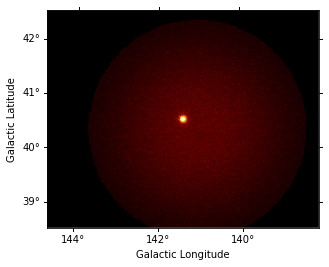

In [100]:
images["counts"].plot();

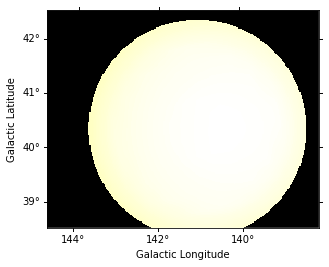

In [101]:
images["background"].plot();

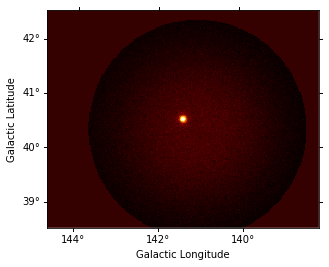

In [102]:
images["excess"].plot();

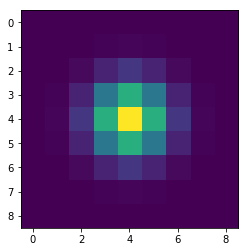

In [103]:
kernel = Gaussian2DKernel(1, mode="oversample").array
plt.imshow(kernel);

In [104]:
%%time
ts_image_estimator = TSMapEstimator()
images_ts = ts_image_estimator.run(images, kernel)
print(images_ts.keys())

dict_keys(['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter'])
CPU times: user 349 ms, sys: 34.2 ms, total: 384 ms
Wall time: 4.69 s


In [105]:
sources = find_peaks(images_ts["sqrt_ts"], threshold=8)
sources

value,x,y,ra,dec
,,,deg,deg
float32,int64,int64,float64,float64
186.08,124,99,148.93081,69.67708
16.675,120,83,148.04284,69.79635
16.365,144,95,149.42349,70.04807
16.252,147,76,148.61694,70.31870
15.417,149,95,149.59688,70.12877
15.211,113,90,148.14327,69.60145
15.103,122,89,148.39363,69.76032
15.097,142,103,149.73134,69.92119


In [106]:
source_pos = SkyCoord(sources["ra"], sources["dec"])
source_pos

<SkyCoord (ICRS): (ra, dec) in deg
    [(148.93081082, 69.67708146), (148.04283877, 69.79634726),
     (149.42349443, 70.04806959), (148.61693768, 70.31869775),
     (149.59688122, 70.12877311), (148.14327015, 69.60144873),
     (148.39363361, 69.76032432), (149.7313363 , 69.92119093),
     (148.20380931, 70.05040275), (149.92614519, 70.14563461),
     (148.4488698 , 70.06501817), (150.27937741, 70.10588588),
     (149.59992525, 70.02877853), (148.28978162, 69.88327392),
     (149.56548022, 69.64063076), (149.04107726, 69.96991835),
     (147.91093457, 70.04684221), (149.20740709, 70.15097696),
     (148.59424039, 69.85833385), (149.27660608, 70.18336183),
     (147.84088677, 69.94184227), (150.01066944, 69.9497569 ),
     (148.41724393, 70.29279674), (149.1278808 , 69.8744616 ),
     (148.2804871 , 69.98322192), (149.79431933, 70.25336528),
     (147.62354538, 70.18700758), (150.01171842, 69.8497578 ),
     (147.47074776, 70.00455224), (148.05526498, 70.01263471),
     (149.49972538, 

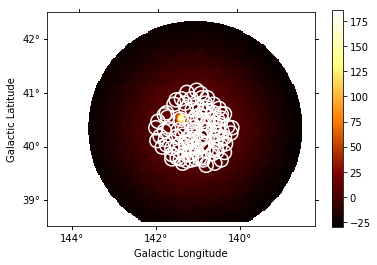

In [107]:
# Plot sources on top of significance sky image
images_ts["sqrt_ts"].plot(add_cbar=True)

plt.gca().scatter(
    source_pos.ra.deg,
    source_pos.dec.deg,
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="white",
    marker="o",
    s=200,
    lw=1.5,
);

In [92]:
%%time
extract = SpectrumExtraction(
    observations=observations, bkg_estimate=bkg_estimate
)
extract.run()

CPU times: user 852 ms, sys: 16 ms, total: 868 ms
Wall time: 1.03 s


In [93]:
%%time
model = models.PowerLaw(
    index=2, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

for dataset in extract.spectrum_observations:
    dataset.model = model

fit = Fit(extract.spectrum_observations)
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 78
	total stat : 4012.85

CPU times: user 431 ms, sys: 0 ns, total: 431 ms
Wall time: 541 ms


In [94]:
# Flux points are computed on stacked observation
from gammapy.spectrum import SpectrumDatasetOnOffStacker

stacker = SpectrumDatasetOnOffStacker(extract.spectrum_observations)
stacked_obs = stacker.run()

print(stacked_obs)

In [95]:
ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit=u.TeV)

stacked_obs.model = model

fpe = FluxPointsEstimator(datasets=[dataset], e_edges=ebounds)
flux_points = fpe.run()
flux_points.table_formatted


e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,loglike,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],dloglike_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.565,1.000,2.448,4.992e-13,7.270e-13,1.095e-12,1.222e-12,1.170,24.720,0.027,4211,0.028,0.027,1.225,52.381,2743.732,0.200 .. 5.000,1791.5217517003548 .. 8905.259373348661,5.840e-13,6.117e-13,1.366e-14,1.384e-14,1.349e-14
3.831,2.448,5.995,7.762e-14,2.768e-13,1.020e-12,1.139e-12,0.899,2.789,0.026,2266,0.026,0.025,0.951,44.719,1999.781,0.200 .. 5.000,1099.455461485934 .. 8969.772643668519,6.981e-14,7.381e-14,1.980e-15,1.991e-15,1.968e-15
10.000,5.995,16.681,1.057e-14,1.137e-13,1.082e-12,1.057e-12,0.726,7.346,0.030,939,0.030,0.030,0.787,31.389,985.262,0.200 .. 5.000,457.2758252475552 .. 5636.719064104861,7.668e-15,8.318e-15,3.186e-16,3.218e-16,3.155e-16
26.102,16.681,40.842,1.439e-15,3.494e-14,8.778e-13,9.800e-13,0.674,7.563,0.044,259,0.045,0.043,0.766,23.316,543.650,0.200 .. 5.000,220.20994319178362 .. 2166.3143385330827,9.700e-16,1.102e-15,6.340e-17,6.474e-17,6.208e-17


In [96]:
model.parameters.covariance = result.parameters.covariance
flux_points_dataset = FluxPointsDataset(data=flux_points, model=model)

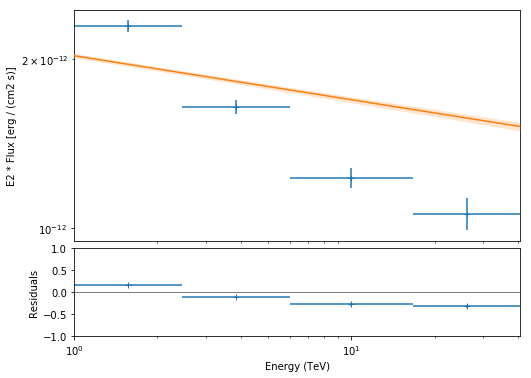

In [97]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();